# Using Mitiq with Qiskit quantum programs

This notebook shows how to use Mitiq to mitigate errors in Qiskit quantum programs.

**This has been adapted to mitigate error from a 16-bit floating point build of Qrack, as a "noisy simulator".**

Truncation error (to improve execution time) of simulation motivates a use case for error mitigation.

The main sections are:
* **Section 1: Computing quantum expectation values without error mitigation**
* **Section 2: Applying zero-noise extrapolation (ZNE)**
* ~~**Section 3: Applying probabilistic error cancellation (PEC)**~~

Useful links:
* Qiskit repository: https://github.com/Qiskit/qiskit
* Qiskit documentation: https://qiskit.org/documentation/
* IBMQ portal: https://www.ibm.com/quantum-computing/


* Mitiq repository: https://github.com/unitaryfund/mitiq
* Mitiq documentation: https://mitiq.readthedocs.io/en/stable/
* Mitiq white paper: https://mitiq.readthedocs.io/en/stable/
* Unitary Fund:  https://unitary.fund

This notebook requires the Python packages: `qiskit-qrack-provider`, `qiskit`, `cirq` and `mitiq`. If necessary, uncomment the next code cell to install them.

In [1]:
!pip install qiskit-qrack-provider --quiet
!pip install qiskit --quiet
!pip install cirq --quiet
!pip install mitiq --quiet

In [2]:
import warnings

warnings.filterwarnings(action='ignore') # Optional warning filter

## Section 1: Computing quantum expectation values without error mitigation

### Define the circuit of interest

We first define an arbitrary circuit of interest. We randomly initialize the qubit width with single qubit gates and then run a QFT algorithm.

In [3]:
import math
import random
import cirq
from mitiq.interface import convert_to_mitiq, convert_from_mitiq

n_qubits = 10

qubits = cirq.LineQubit.range(n_qubits)
circuit = cirq.Circuit()
for i in range(n_qubits):
    # Initialize with uniformly random single qubit gates, across full width.
    circuit.append(cirq.rx(random.uniform(0, 2 * math.pi)).on(qubits[i]))
    circuit.append(cirq.ry(random.uniform(0, 2 * math.pi)).on(qubits[i]))
    circuit.append(cirq.rz(random.uniform(0, 2 * math.pi)).on(qubits[i]))
circuit.append(cirq.qft(*qubits, without_reverse=True))

circuit = convert_from_mitiq(convert_to_mitiq(circuit)[0], "qiskit")

print(f"Randomized benchmarking circuit with {len(circuit)} gates generated.")
# print(circuit)

Randomized benchmarking circuit with 580 gates generated.


### Execute the circuit with an noiseless backend

In [4]:
import qiskit

# Set the number of shots 
shots = 10 ** 6

# Initialize ideal backend (classical noiseless simulator)
ideal_backend = qiskit.Aer.get_backend('aer_simulator')

# Append measurements
circuit_to_run = circuit.copy()
circuit_to_run.measure_all()

# Run and get count
job = ideal_backend.run(circuit_to_run, shots=shots)
counts = job.result().get_counts()

key = max(counts)

# Expectation value
ideal_value = (counts[key] if key in counts else 0) / shots
ideal_value

0.000122

### Execute the circuit with an noisy backend (without error mitigation)

In [5]:
from qiskit.providers.qrack import Qrack

# Select a noisy backend
noisy_backend = Qrack.get_backend('qasm_simulator')

# Append measurements
circuit_to_run = circuit.copy()
circuit_to_run.measure_all()

# Run and get counts
print(f"Executing circuit with {len(circuit)} gates using {shots} shots.")
job = noisy_backend.run(circuit_to_run, shots=shots)
counts = job.result().get_counts()

# Compute expectation value of the observable
noisy_value = (counts[key] if key in counts else 0) / shots
noisy_value

Executing circuit with 580 gates using 1000000 shots.
Device #0, Loaded binary from: /home/iamu/.qrack/qrack_ocl_dev_NVIDIA_GeForce_RTX_3080_Laptop_GPU.ir


0.064237

## Section 2: Applying zero-noise extrapolation (ZNE)

### Define an executor function

We rewrite the last code cell of the previous section as a function that we call `executor`.
This function takes as input a Qiskit circuit and returns the final noisy expectation value.

Hint: It is usually better, but not necessary, to set `optimization_level=0` to avoid automatic circuit optimizations.

In [6]:
def executor(circuit, shots=shots):
    """Executes the input circuit and returns the noisy expectation value <A>, where A=|00>00|.
    """
    # Select a noisy backend
    # noisy_backend = qiskit.IBMQ.load_account().get_backend("ibmq_lima")
    # noisy_backend = FakeLima() # Simulator with noise model similar to "ibmq_lima"
    noisy_backend =  Qrack.get_backend('qasm_simulator')

    # Append measurements
    circuit_to_run = circuit.copy()
    circuit_to_run.measure_all()

    # Run and get counts
    print(f"Executing circuit with {len(circuit)} gates using {shots} shots.")
    job = noisy_backend.run(circuit_to_run, shots=shots)
    counts = job.result().get_counts()

    # Compute expectation value of the observable
    noisy_value = (counts[key] if key in counts else 0) / shots
    return noisy_value  

In [7]:
noisy_value = executor(circuit)
noisy_value

Executing circuit with 580 gates using 1000000 shots.


0.06539

### Run zero-noise extrapolation with Mitiq

In [8]:
from mitiq import zne

zne_value = zne.execute_with_zne(circuit, executor)

unmitigated_error = abs(ideal_value - noisy_value)
zne_error = abs(ideal_value - zne_value)
print(f"Estimation error without Mitiq   : {unmitigated_error}")
print(f"Estimation error with Mitiq (ZNE): {zne_error}")

Executing circuit with 580 gates using 1000000 shots.
Executing circuit with 1328 gates using 1000000 shots.
Executing circuit with 2100 gates using 1000000 shots.
Estimation error without Mitiq   : 0.065268
Estimation error with Mitiq (ZNE): 0.03715199999999991


In [9]:
print(f"ZNE reduced the estimation error by {(unmitigated_error - zne_error) / unmitigated_error :.1%}.")

ZNE reduced the estimation error by 43.1%.


Below we show how to select different options for zero-noise extrapolation.

### Select a noise scaling method

In [10]:
# Choise a unitary folding function
noise_scaling_function = zne.scaling.fold_global

Let's check the effect of the noise scaling function on the input circuit:

In [11]:
noise_scaled_circuit = noise_scaling_function(circuit, scale_factor=2)

print(f"The input circuit has {len(circuit)} gates")
print(f"The scaled circuit has {len(noise_scaled_circuit)} gates")

The input circuit has 580 gates
The scaled circuit has 1340 gates


### Select an extrapolation model

In [12]:
factory = zne.inference.RichardsonFactory(scale_factors = [1, 2, 3])

# Examples:

# Richardson extrapolation
# factory = zne.inference.RichardsonFactory(scale_factors = [1, 2, 3])

# Exponential extrapolation
# factory = zne.inference.ExpFactory(scale_factors = [1, 2, 3], asymptote=0.25)

# Exponential adaptive extrapolation
# factory = zne.inference.AdaExpFactory(steps=10, asymptote=0.25)

### Apply ZNE with non-default options

In [13]:
zne_value = zne.execute_with_zne(circuit, executor, scale_noise=noise_scaling_function, factory=factory)

unmitigated_error = abs(ideal_value - noisy_value)
zne_error = abs(ideal_value - zne_value)
print(f"Estimation error without Mitiq   : {unmitigated_error}")
print(f"Estimation error with Mitiq (ZNE): {zne_error}")

Executing circuit with 580 gates using 1000000 shots.
Executing circuit with 1340 gates using 1000000 shots.
Executing circuit with 2100 gates using 1000000 shots.
Estimation error without Mitiq   : 0.065268
Estimation error with Mitiq (ZNE): 0.0011449999999999046


In [14]:
print(f"ZNE reduced the estimation error by {(unmitigated_error - zne_error) / unmitigated_error :.1%}.")

ZNE reduced the estimation error by 98.2%.


### Analize and visualize ZNE data 

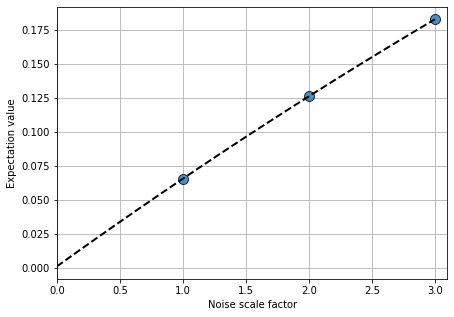

In [15]:
_ = factory.plot_fit()

In [16]:
factory.get_expectation_values()

array([0.065745, 0.126291, 0.182905])

In [17]:
factory.get_scale_factors()

array([1, 2, 3])

In [18]:
factory.get_zero_noise_limit()

0.0012669999999999045